In [1]:
import numpy as np
import pylab as pl
from astropy.io import fits
from matplotlib import cm
cmap = cm.get_cmap('gray')
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import exposure
%matplotlib inline
import pandas as pd


## data input

In [2]:
calib_data = 'data/ALICE_Machine-Learning/ALICE_RefCube_F110W_Era-2.fits'
calibdata = fits.open(calib_data)



In [3]:
calibdata[0].shape

(809, 80, 80)

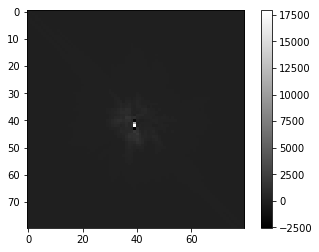

In [4]:
raw = calibdata[0].data

image_data = raw[6]
plt.imshow(image_data, cmap='gray')
plt.colorbar()


In [5]:
cube = calibdata[0].data
Nframes = len(cube[:,0,0])
Ny  = 64
Nx  = 64

# ylow = 325
# xlow = 550

ylow = 10
xlow = 10

cube_cut = np.zeros((Nframes,Nx,Ny))
for i in range(Nframes):
    cube_cut[i,:,:] = cube[i,ylow:ylow+Ny,xlow:xlow+Nx]

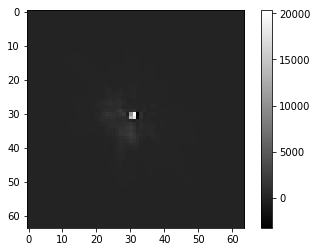

In [6]:

over_data = cube_cut[13]
plt.imshow(over_data, cmap='gray')
plt.colorbar()

In [7]:
# fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
# axs[0].imshow(over_data, cmap='gray')
# axs[0].set_title("w/ saturated pixel")
# axs[1].imshow(new_image, cmap='gray')
# axs[1].set_title("saturated pixel removed")
# axs[2].imshow(image_data, cmap='gray')
# axs[2].set_title("reference (w/o saturated pixel)")
# plt.savefig("cleaned_img")

In [8]:
##remove overly saturated pixels and replace with interpolated ones
def find_outlier_pixels(data,tolerance=3,blur = 3):
    #This function finds the hot or dead pixels in a 2D dataset. 
    #tolerance is the number of standard deviations used to cutoff the hot pixels
    #If you want to ignore the edges and greatly speed up the code, then set
    #worry_about_edges to False.
    #
    #The function returns a list of hot pixels and also an image with with hot pixels removed

    from scipy.ndimage import median_filter
    
    blurred = median_filter(data, size=blur)
    difference = data - blurred
    threshold = 10*np.std(difference)

    #find the hot pixels, but ignore the edges
    hot_pixels = np.nonzero((difference[1:-1,1:-1]>threshold) )
    hot_pixels = np.array(hot_pixels) + 1 #because we ignored the first row and first column
    fixed_image = np.copy(data) #This is the image with the hot pixels removed
    for y,x in zip(hot_pixels[0],hot_pixels[1]):
        fixed_image[y,x]=blurred[y,x]

    dead_pixels = np.nonzero(data<-10)
    for y,x in zip(dead_pixels[0],dead_pixels[1]):
        fixed_image[y,x]=blurred[y,x]

    return fixed_image,blurred

Mean: 2.24262905121


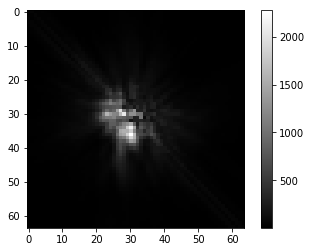

In [9]:
#inspect the cleaned image
new_image,blurred = find_outlier_pixels(cube_cut[13])
plt.imshow(new_image, cmap='gray')
plt.colorbar()
print('Mean:', np.min(new_image))

In [10]:
##new data cube with cleaned images inside

white_out_list = np.array([])
new_data_cube = []
for i in range(len(cube_cut)):
    if np.max(cube_cut[i]) > 10000:
        white_out_list = np.append(white_out_list,i)
        new_image,_ = find_outlier_pixels(cube_cut[i])
        new_data_cube.append(new_image)
    else:
        new_data_cube.append(cube_cut[i])

new_data_cube = np.array(new_data_cube)
np.max(new_data_cube)
## leave out images that are still overly saturated. 
data_cube_with_cleaned = []
for i in range(len(new_data_cube)):
    if np.max(new_data_cube[i]) > 10000:
        pass
    else:
        data_cube_with_cleaned.append(new_data_cube[i])

In [ ]:
np.array(data_cube_with_cleaned).shape

In [11]:
## alternative.
### new data cube without images with overly-saturated points. 
data_cube_without_saturation = []
for i in range(len(cube_cut)):
    if np.max(cube_cut[i]) > 10000:
        pass
    else:
        data_cube_without_saturation.append(cube_cut[i])



In [12]:
np.array(data_cube_without_saturation).shape

(742, 64, 64)

In [13]:
#normalisation
def normalise_cube(data):
    
    print(np.min(data))
    print(np.max(data))
    data[data<0] = 0
    new_data = data - np.min(data)
    new_data = data / np.max(data)

    print(np.min(new_data))
    print(np.max(new_data))
    print("normaliastion completed")
    return new_data
    

In [36]:
def local_normal(data):
    data[data<0] = 0
    new_imgs_list = []
    for imgs in data:
        local_min = np.min(imgs)
        local_max = np.max(imgs)
        new_imgs = imgs - local_min
        new_imgs = new_imgs/local_max
        new_imgs_list.append(new_imgs)
    return np.array(new_imgs_list).reshape(-1,64,64)

## Data augmentation


In [14]:
import imgaug as ia 
from imgaug import augmenters as iaa

In [15]:
#train test split
from sklearn.model_selection import train_test_split
X = data_cube_without_saturation
X_train, X_test = train_test_split(X, test_size=0.10, random_state=42)


In [16]:
np.shape(X_train),np.shape(X_test)

((667, 64, 64), (75, 64, 64))

In [55]:
def add_salt_pepper_noise(X_imgs,sp_ratio=0.5,number=0.0006):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col = X_imgs_copy.shape
    salt_vs_pepper = sp_ratio
    amount = number
    num_salt = np.ceil(amount * X_imgs_copy.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy.size * (1.0 - salt_vs_pepper))

        # Add Salt noise
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_imgs_copy.shape]
    X_imgs_copy[coords[0], coords[1]] = 1
        # Add Pepper noise
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_imgs_copy.shape]
    X_imgs_copy[coords[0], coords[1]] = 0
    return X_imgs_copy

In [56]:
def add_gaussian_noise(X_imgs,mean = 0,sigma = 0.1):
    row, col= X_imgs.shape
    gauss = np.random.normal(mean,sigma,(row,col))    
    new_img = X_imgs + gauss

    return new_img
  


In [82]:
#make all negative pixels zero.
X_train = np.array(X_train)
X_test = np.array(X_test)


In [83]:
nor_train = local_normal(X_train)
nor_test = local_normal(X_test)

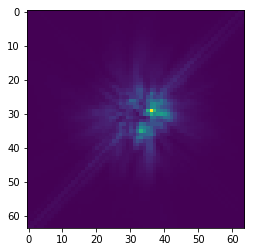

In [25]:
fliper = iaa.Fliplr(1)
test_flipped = fliper.augment_image(test)
plt.imshow(test_flipped)

In [73]:
##Data augmenation pipeline. 

def data_aug(data,check_img = False):
    ##adding gaussian noise
    length = len(data)
    noise_list = np.arange(0,12,2)
    randn_list = np.random.randint(len(noise_list),size=length)
    noise_imgs = []
    for idx,imgs in enumerate(data):
        gaus_imgs = add_gaussian_noise(imgs,noise_list[randn_list[idx]],sigma=0.5)
        if (check_img == True & idx == 300):
            plt.imshow(gaus_imgs)
            plt.show()
        noise_imgs.append(gaus_imgs)
    noise_imgs = np.array(noise_imgs).reshape(-1,64,64)
    ##normalisation
    nor_train = local_normal(noise_imgs)
    ##add salt and pepper
    augmented_imgs = []
    sp_ratio_list = np.arange(0.1, 0.8,0.1)
    freq = np.arange(0.01,0.04,0.005)
    scale_list = np.arange(1.0,1.6, 0.05)
    rotate_list = np.arange(-90,180,90)
    randn_list2 = np.random.randint(len(sp_ratio_list),size=length)
    randn_list3 = np.random.randint(len(freq),size=length)
    randn_list4 = np.random.randint(len(scale_list),size=length)
    randn_list5 = np.random.randint(2,size = length)
    randn_list6 = np.random.randint(2,size = length)
    randn_list7 = np.random.randint(len(rotate_list),size=length)
    for idx,imgs in enumerate(nor_train):
        enlarger = iaa.Affine(scale=scale_list[randn_list4[idx]])
        scaled_imgs = enlarger.augment_image(imgs)
        if (check_img == True & idx == 300):
            plt.imshow(scaled_imgs)
            plt.show()
        seasoned = add_salt_pepper_noise(scaled_imgs,sp_ratio=sp_ratio_list[randn_list2[idx]],number=freq[randn_list3[idx]])
        if (check_img == True & idx == 300):
            plt.imshow(seasoned)
            plt.show()
        fliperlr = iaa.Fliplr(randn_list5[idx])
        fliperud = iaa.Flipud(randn_list6[idx])
        flip_imgs = fliperlr.augment_image(seasoned)
        flip_imgs = fliperud.augment_image(flip_imgs)
        if (check_img == True & idx == 300):
            plt.imshow(flip_imgs)
            plt.show()
        rotator = iaa.Affine(rotate=rotate_list[randn_list7[idx]])
        rotate_imgs = rotator.augment_image(flip_imgs)
        if (check_img == True & idx == 300):
            plt.imshow(rotate_imgs)
            plt.show()
        
        augmented_imgs.append(rotate_imgs)
    
    return np.array(augmented_imgs).reshape(-1,64,64)
        
    
        
        

In [74]:
#test 
aug_images = data_aug(X_train)

In [105]:
aug_images.shape
aug_data_cube = []
for i in range(8):
    aug_images = data_aug(X_train)
    aug_data_cube.append(aug_images)
aug_data_cube = np.array(aug_data_cube).reshape(-1,64,64)

In [106]:
aug_data_cube.shape

(5336, 64, 64)

# Interpolation to create new images

In [ ]:
np.shape(training)

weight = np.arange(0.1,1,0.1)

print(weight)
new_img_list = np.array([])
for i in range(1):
    test_img = training[i]
    for j in range(5):
        if i != j:
            test_img2 = training[j]
            new_img = np.zeros_like(test_img)
            randint = np.random.randint(len(weight))
            for k in range(len(test_img)):
                new_img[k] += (weight[randint]*test_img[k] +(1-weight[randint])*test_img2[k])/1
            new_img_list = np.append(new_img_list,new_img)    

new_img_list = new_img_list.reshape(-1,64,64)
new_img_list.shape
for i in range(len(new_img_list)):
    print(np.max(new_img_list[i]),np.min(new_img_list[i]),np.mean(new_img_list[i]))

## stacking cube and normalisation

In [107]:
train_image = np.vstack([nor_train,aug_data_cube])
train_image.shape

(6003, 64, 64)

In [108]:
np.save('HST_aug_data_6000', train_image)
np.save('HST_aug_data_test', nor_test)

0.0

## check the residual between calib. stars

In [ ]:
normalised_training_set = normalise_cube(data_cube_without_saturation)

In [ ]:
mean_img = np.mean(normalised_training_set,axis=0)

In [ ]:
residual_block = normalised_training_set - mean_img